# Exploring building reference datasets with kerchunk

The idea: build a test intake catalogue of kerchunk virtual dataset(s) from the COSIMA output(s) and see how it performs

In [1]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake


In [2]:
import os
import glob

import ujson

import fsspec

import zarr

import pandas as pd

import xarray as xr

from distributed import Client

from kerchunk import hdf, combine, df
import fsspec.implementations.reference

In [3]:
client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

# Build a reference dataset for all cycles of `access-om2-025` `025deg_jra55_iaf_omip2` `ocean_month` data (~13TB compressed, ~50TB uncompressed, 366 netcdf files)

I ran these cells with a hugemem node

In [4]:
exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle*"

files = sorted(glob.glob(f"{exp_root}/output*/ocean/ocean_month.nc"))

## Prepare combined kerchunk virtual dataset in parallel

This takes just under 1 hour

In [ ]:
%%time

def get_cycle(index, fs, var, fn):
    import re
    cycle = re.search('cycle(\d+)', fn)[1]
    return int(cycle)

mzz = auto_dask(
    files,
    single_driver=hdf.SingleHdf5ToZarr,
    single_kwargs={},
    mzz_kwargs=dict(
        coo_map={"cycle": get_cycle},
        concat_dims=["time", "cycle"],
        identical_dims=[
            "xt_ocean", 
            "yt_ocean", 
            "st_ocean", 
            "xu_ocean", 
            "yu_ocean", 
            "sw_ocean", 
            "grid_xt_ocean", 
            "grid_yt_ocean", 
            "grid_xu_ocean", 
            "grid_yu_ocean", 
            "potrho", 
            "neutral",
            "nv"
         ]
    ),
    n_batches=14,
)

## Write to a json file

In [7]:
with open("./025deg_jra55_iaf_omip2.ocean_month.json", 'wb') as f:
    f.write(ujson.dumps(mzz).encode());

## Consolidate metadata

In [8]:
m = fsspec.get_mapper(
    'reference://', 
    fo="025deg_jra55_iaf_omip2.ocean_month.json", 
    remote_protocol="file"
)
zarr.convenience.consolidate_metadata(m)
m.fs.save_json("./025deg_jra55_iaf_omip2.ocean_month.consolidated.json")

## Write to parquet

In [9]:
os.mkdir("./025deg_jra55_iaf_omip2.ocean_month.parq")
df.refs_to_dataframe(mzz, "./025deg_jra55_iaf_omip2.ocean_month.parq", partition=True)

# Compute on the reference datasets and compare to `open_mfdataset`

## 1. Reference JSON dataset

In [4]:
%%time

m = fsspec.get_mapper(
    'reference://', 
    fo="./025deg_jra55_iaf_omip2.ocean_month.consolidated.json", 
    remote_protocol="file"
)

ds = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": True},
    chunks="auto",
    decode_times=False
)

CPU times: user 1min 22s, sys: 17.3 s, total: 1min 40s
Wall time: 1min 39s


In [8]:
%%time

# This compute comprises 733 dask tasks and needs ~16GB memory per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 33.3 s, sys: 5.26 s, total: 38.6 s
Wall time: 6min 49s


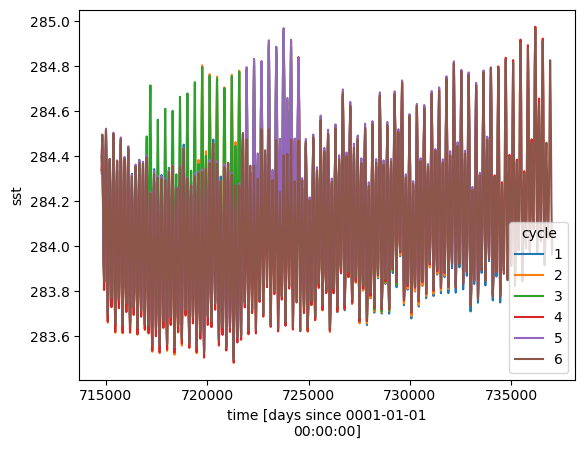

In [10]:
_ = global_mean.plot.line(x="time")

## 2. Reference parquet dataset

In [4]:
%%time

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "025deg_jra55_iaf_omip2.ocean_month.parq", lazy=True
).get_mapper()

ds = xr.open_dataset(
    m,
    engine="zarr",
    backend_kwargs={"consolidated": False},
    decode_times=False,
    chunks="auto"
)

CPU times: user 10.4 s, sys: 1.54 s, total: 12 s
Wall time: 13.9 s


In [5]:
%%time

# This compute comprises 733 dask tasks and needs ~1.5GB per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 20.6 s, sys: 2.73 s, total: 23.4 s
Wall time: 3min 35s


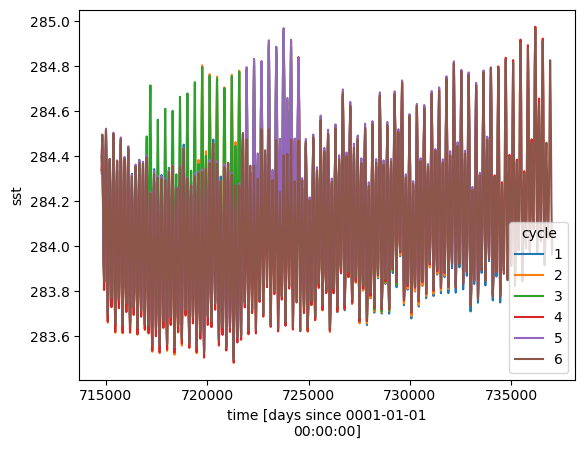

In [6]:
_ = global_mean.plot.line(x="time")

## 3. `open_mfdataset`

In [4]:
%%time

exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle?"

files = []
for cycle in sorted(glob.glob(exp_root)):
    files.append(sorted(glob.glob(f"{cycle}/output*/ocean/ocean_month.nc")))

ds = []
for f in files:
    ds.append(
        xr.open_mfdataset(
            f,
            chunks="auto",
            concat_dim="time",
            parallel=True,
            combine="nested",
            data_vars="minimal", 
            coords="minimal", 
            compat="override"
        )
    )
    
ds = xr.concat(ds, dim=pd.Index(range(len(files)), name="cycle"))

CPU times: user 41.4 s, sys: 2.11 s, total: 43.5 s
Wall time: 1min


In [5]:
%%time

# This compute comprises 1830 dask tasks and uses ~700MB of memory per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 17.6 s, sys: 1.62 s, total: 19.2 s
Wall time: 1min 51s


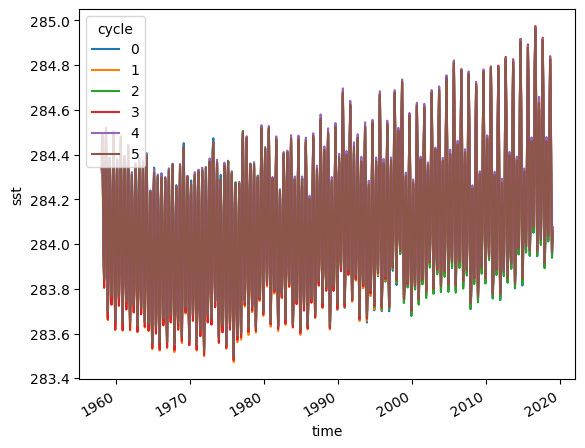

In [6]:
_ = global_mean.plot.line(x="time")

## Notes (some outdated)

- The main impediment to this sort of approach at the moment is that kerchunk references are stored as inefficient json files which can be very large for datasets comprising many chunks. Currently this entire file is loaded with `open_dataset` (and loaded onto each worker when using a distributed cluster) which can require lots of memory and overhead. This outweighs the benefits kerchunk provides in this application (consolidation + zarr simplicity/performance).

- This said, there are a number of things in the kerchunk pipeline that should address the above issue: 1) new data structures for the reference set(s) that facilitate lazy loading (see https://github.com/fsspec/kerchunk/issues/240 and https://github.com/fsspec/kerchunk/issues/134), 2) the ability the split/combine chunks within a reference file but this would have limitations (e.g. couldn't work for particular types of compression, see https://github.com/fsspec/kerchunk/issues/124 and https://github.com/fsspec/kerchunk/issues/134).

- The approach of generating reference datasets for new experiments should be relatively straight-forward if we can have some confidence that all input files will be readily "concatenatable" in the sense that they have the same chunking patterns, coordinates on fixed dims, fixed auxiliary coordinates, variables (where approapriate) etc. The latest functionality for combining references in kerchunk is pretty versatile, see https://fsspec.github.io/kerchunk/tutorial.html#using-coo-map.

- Where the raw data are unchunked (e.g. netcdf3), this approach can significantly impact performance since fsspec will make the full range request even for subsets (https://github.com/fsspec/kerchunk/issues/124).

In [ ]:
client.close()